# Attempting to estimate the time to 1M (confirmed) infections of Covid-19 in the US
Based on CDC data and some naive curve fitting

## Imports

In [193]:
from datetime import datetime, timedelta
import json

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

## Get data

In [49]:
# had to poke around source to find this; assume it is update frequently
cdc_covid19_url = 'https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json'

## Massage into pandas objects

In [68]:
r = requests.get(cdc_covid19_url)
js = json.loads(r.text)
ser = pd.Series(index=js['data']['columns'][0][1:], data=map(int, js['data']['columns'][1][1:]))

In [73]:
ser_cs = ser.cumsum()

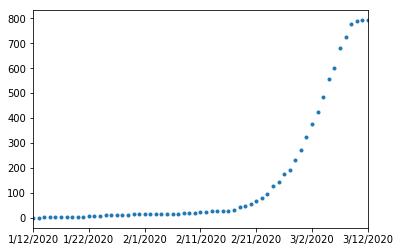

In [79]:
ser_cs.plot(style='.')

## Curve fitting

### Pick data to fit

In [118]:
time_delay  = 7 # don't include last 7 days-- not all cases have been reported yet
y = ser_cs.values
x = list(range(len(y)))
y_trunc = y[:-time_delay+1]
x_trunc = list(range(len(y_trunc)))

### Fit with scipy.optimize.curve_fit for an exponential

In [164]:
from scipy.optimize import curve_fit, root_scalar

In [149]:
def exp_func(x, a, b, c):
    return c + a*np.exp(b*x)

In [165]:
# there is some noisiness at the start the messes with the fit-- exclude
early_count_exclusion_days = 36
exp_params, params_covar = curve_fit(exp_func, x_trunc[early_count_exclusion_days:], y_trunc[early_count_exclusion_days:])

### Fit with np.polyfit for a polynomial

In [157]:
p = np.polyfit(x_trunc, y_trunc, 3)

In [158]:
poly = np.poly1d(p)

### Plot

In [160]:
def rss(y_exp: float, y_fitted: float) -> float:
    return np.sum(np.power(np.subtract(y_exp, y_fitted), 2))

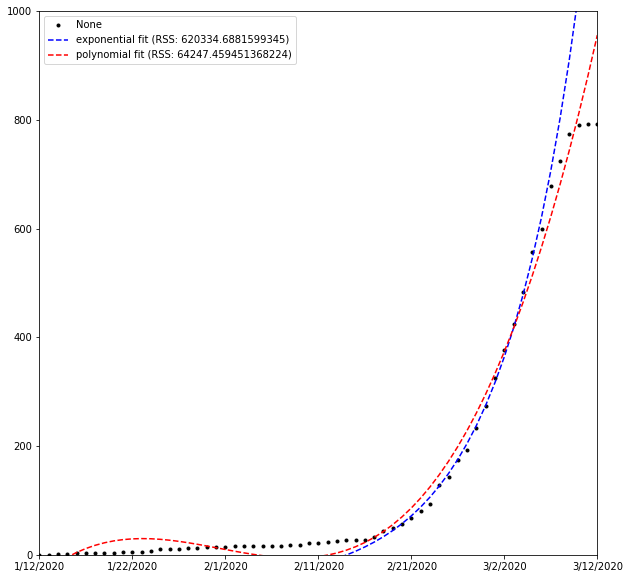

In [166]:
f, a = plt.subplots(figsize=(10, 10))

ser_cs.plot(style='.', color='black', ax=a)
exp_y = list(map(lambda z: exp_func(z, *exp_params), x))
poly_y = list(map(poly, x))
a.plot(x, exp_y, '--', color='blue', label=f'exponential fit (RSS: {rss(y, exp_y)})')
a.plot(x, poly_y, '--', color='red', label=f'polynomial fit (RSS: {rss(y, poly_y)})')


a.set_ylim([0, 1000])
a.legend()

In [167]:
# modify to predict when we hit the million mark
def exp_func_root(x, population_mark=1e6):
    return exp_func(x, *exp_params) - population_mark
def poly_root(x, population_mark=1e6):
    return poly(x) - population_mark

In [191]:
first_case = datetime.strptime(ser[ser > 0].sort_index().index[0], "%m/%d/%Y")

In [211]:
exp_sol = root_scalar(exp_func_root, bracket=[0, 120], method='brentq')
# translate to days
exp_million_cases_date = first_case + timedelta(exp_sol.root)
print(f'Millionth case (exponential fit): {exp_million_cases_date.year}/{exp_million_cases_date.month}/{exp_million_cases_date.day}')

Millionth case (exponential fit): 2020/5/8


In [210]:
poly_sol = root_scalar(poly_root, bracket=[0, 500], method='brentq')
# translate to days
poly_million_cases_date = first_case + timedelta(poly_sol.root)
print(f'Millionth case (polynomial fit): {poly_million_cases_date.year}/{poly_million_cases_date.month}/{poly_million_cases_date.day}')

Millionth case (polynomial fit): 2021/3/5
